<a href="https://colab.research.google.com/github/ngoniematt/BERT-Model-for-Depression-Severity-Prediction/blob/main/DISTILBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"


In [ ]:
!pip install transformers
!pip install torch
!pip install emoji
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

#1. Setup and Seed Initialization
import os
import random
import numpy as np
import torch
from transformers import set_seed, BertTokenizer, BertModel
from torch.optim import AdamW

# Set Python hash seed
os.environ['PYTHONHASHSEED'] = '42'

# Set seeds for Python, NumPy, and PyTorch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set HuggingFace transformers seed
set_seed(42)

# Force deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print("Could not enforce deterministic algorithms:", e)


In [ ]:
#2. Mount Google Drive and Import Other Libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import emoji
import contractions
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
# 3. Load and Preprocess the Dataset
file_path = "/content/drive/My Drive/BERTBASE/Final_Depression.csv"
data = pd.read_csv(file_path)

# Select only the necessary columns and drop any missing values
data = data[['Text', 'depression_Intensity']].dropna()

# Preprocessing functions
def expand_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = re.sub(r'@\w+', 'at_user', text)      # Replace mentions (@user)
    text = re.sub(r'http\S+|www\S+', 'url', text)  # Replace URLs
    text = re.sub(r'\s+', ' ', text).strip()       # Remove extra spaces
    return text

def preprocess_text(text):
    text = expand_contractions(text)  # Expand contractions (optional)
    text = clean_text(text)           # Light text cleaning
    return text

# Apply preprocessing to the text
data["Cleaned_Text"] = data["Text"].apply(preprocess_text)

In [ ]:
from transformers import AutoTokenizer, AutoModel
# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

# Optionally encode all texts (not directly used later)
encoded_data = encode_texts(data["Cleaned_Text"], tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# 5. Create Dataset and DataLoader
class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Split dataset into Train, Validation, and Test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["Cleaned_Text"], data["depression_Intensity"], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)

# Tokenize each split
train_encodings = encode_texts(train_texts, tokenizer)
val_encodings = encode_texts(val_texts, tokenizer)
test_encodings = encode_texts(test_texts, tokenizer)

# Create PyTorch datasets
train_dataset = DepressionDataset(train_encodings, train_labels.values)
val_dataset = DepressionDataset(val_encodings, val_labels.values)
test_dataset = DepressionDataset(test_encodings, test_labels.values)

# Define a worker initialization function to seed DataLoader workers
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create a generator for the DataLoader
g = torch.Generator()
g.manual_seed(42)

# Create DataLoaders with reproducibility settings
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         worker_init_fn=seed_worker, generator=g)

In [ ]:
class DistilBERTRegression(nn.Module):
    def __init__(self):
        super(DistilBERTRegression, self).__init__()
        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.regressor = nn.Linear(self.distilbert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]  # Extract CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTRegression().to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_fn = nn.MSELoss()

In [ ]:
# 8. Training Function with Early Stopping
def train_model_bert(model, train_loader, val_loader, optimizer, loss_fn, epochs=20, patience=3, device="cuda"):
    best_val_loss = float("inf")
    patience_counter = 0
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask).squeeze()
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"- Train MSE Loss = {avg_train_loss:.6f}")
        print(f"- Validation MSE Loss = {avg_val_loss:.6f}")

        if (best_val_loss - avg_val_loss) > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "/content/drive/MyDrive/New_Models/DISTILbert_16_model.pth")
        else:
            patience_counter += 1
            print(f"!! No improvement for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break

    print("Training complete :)")



In [ ]:
# 9. Train the Model
EPOCHS = 20
PATIENCE = 3

train_model_bert(model=model,
                 train_loader=train_loader,
                 val_loader=val_loader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=EPOCHS,
                 patience=PATIENCE,
                 device=device)

Epoch 1/20:
- Train MSE Loss = 0.012762
- Validation MSE Loss = 0.003921
Validation loss improved. Saving model...
Epoch 2/20:
- Train MSE Loss = 0.004972
- Validation MSE Loss = 0.003220
Validation loss improved. Saving model...
Epoch 3/20:
- Train MSE Loss = 0.003115
- Validation MSE Loss = 0.006590
!! No improvement for 1 epochs.
Epoch 4/20:
- Train MSE Loss = 0.002421
- Validation MSE Loss = 0.002760
Validation loss improved. Saving model...
Epoch 5/20:
- Train MSE Loss = 0.001924
- Validation MSE Loss = 0.002492
Validation loss improved. Saving model...
Epoch 6/20:
- Train MSE Loss = 0.001606
- Validation MSE Loss = 0.002402
Validation loss improved. Saving model...
Epoch 7/20:
- Train MSE Loss = 0.001346
- Validation MSE Loss = 0.003753
!! No improvement for 1 epochs.
Epoch 8/20:
- Train MSE Loss = 0.001261
- Validation MSE Loss = 0.002284
Validation loss improved. Saving model...
Epoch 9/20:
- Train MSE Loss = 0.001210
- Validation MSE Loss = 0.002697
!! No improvement for 1 epo

In [ ]:
# 10. Evaluation Function
def evaluate_model_bert(model, test_loader, model_path=None, device="cuda"):
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    print(f"\nBERTREGRESSOR Evaluation Results:")
    print(f"- Mean Squared Error (MSE): {mse:.4f}")
    print(f"- R² Score: {r2:.4f}")

    # Convert regression outputs to categorical labels for confusion matrix
    def categorize_depression(intensity):
        if intensity < 0.4:
            return "Non-Depressed"
        elif 0.4 <= intensity < 0.6:
            return "Mild"
        elif 0.6 <= intensity < 0.8:
            return "Moderate"
        else:
            return "Severe"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    cm = confusion_matrix(true_labels_class, predicted_labels_class,
                          labels=["Non-Depressed", "Mild", "Moderate", "Severe"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"],
                yticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class,
                                target_names=["Non-Depressed", "Mild", "Moderate", "Severe"]))

    return mse, r2



Loading best saved model for evaluation...
Model loaded successfully!

BERTREGRESSOR Evaluation Results:
- Mean Squared Error (MSE): 0.0019
- R² Score: 0.7970


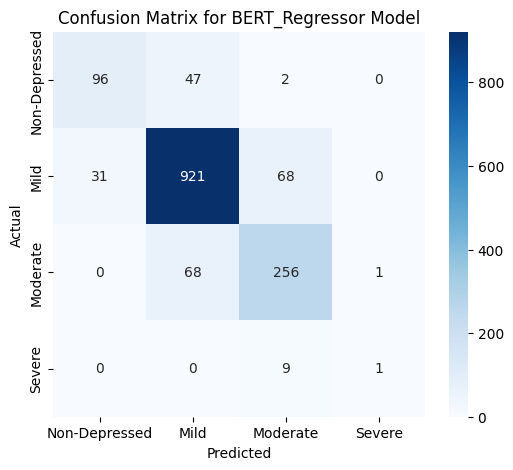


Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.89      0.90      0.90      1020
         Mild       0.76      0.79      0.78       325
     Moderate       0.76      0.66      0.71       145
       Severe       0.50      0.10      0.17        10

     accuracy                           0.85      1500
    macro avg       0.73      0.61      0.64      1500
 weighted avg       0.85      0.85      0.85      1500



(0.0019025576766580343, 0.7970297932624817)

In [ ]:
#11. Evaluate the Model
evaluate_model_bert(model=model,
                    test_loader=test_loader,
                    model_path="/content/drive/MyDrive/New_Models/DISTILbert_16_model.pth",
                    device=device)


In [ ]:
del model  # Delete previous model
torch.cuda.empty_cache()  # Clear GPU memory


In [ ]:
class DistilBERTRegression(nn.Module):
    def __init__(self):
        super(DistilBERTRegression, self).__init__()
        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.regressor = nn.Linear(self.distilbert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]  # Extract CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTRegression().to(device)


In [ ]:
# Create DataLoaders with batch size 32
train_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True,
                             worker_init_fn=seed_worker, generator=g)
val_loader_32 = DataLoader(val_dataset, batch_size=32, shuffle=False,
                           worker_init_fn=seed_worker, generator=g)
test_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=False,
                            worker_init_fn=seed_worker, generator=g)

In [ ]:
# Training Function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_fn = nn.MSELoss()

# Training function with early stopping
def train_model_bert(model, train_loader, val_loader, optimizer, loss_fn, epochs=20, patience=3, device="cuda"):
    """
    Train the DISTILBERT model with early stopping and MSE tracking.

    - Stops training if validation loss does not improve after `patience` epochs.
    - Saves the best model automatically.
    - Applies gradient clipping for stability.
    """

    best_val_loss = float("inf")  # Initialize with a high value
    patience_counter = 0  # Counter to track non-improving epochs
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(outputs, labels)  # Compute MSE loss
            loss.backward()

            # Apply gradient clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            total_train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = (
                    batch["input_ids"].to(device),
                    batch["attention_mask"].to(device),
                    batch["labels"].to(device),
                )

                outputs = model(input_ids, attention_mask).squeeze()
                loss = loss_fn(outputs, labels)  # Compute MSE loss
                total_val_loss += loss.item()

        # Compute average validation loss
        avg_val_loss = total_val_loss / len(val_loader)

        # Print loss values for this epoch
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"-Train MSE Loss = {avg_train_loss:.6f}")
        print(f"-Validation MSE Loss = {avg_val_loss:.6f}")

        # **Early Stopping Logic**
        if (best_val_loss - avg_val_loss )>min_delta:
            best_val_loss = avg_val_loss  # Update best loss
            patience_counter = 0  # Reset patience counter
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "/content/drive/MyDrive/New_Models/DISTILbert_32_model.pth")
        else:
            patience_counter += 1  # Increment patience counter
            print(f"!!No improvement for {patience_counter} epochs.")

        # **Trigger Early Stopping if No Improvement for `patience` epochs**
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break  # Stop training

    print("Training complete :)")

# Call the training function to start training
EPOCHS = 20  # Increased epochs
PATIENCE = 3  # Stop if no improvement for 3 epochs

train_model_bert(
    model=model,
    train_loader=train_loader_32,
    val_loader=val_loader_32,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)


Epoch 1/20:
-Train MSE Loss = 0.006834
-Validation MSE Loss = 0.003920
Validation loss improved. Saving model...
Epoch 2/20:
-Train MSE Loss = 0.004085
-Validation MSE Loss = 0.003156
Validation loss improved. Saving model...
Epoch 3/20:
-Train MSE Loss = 0.002867
-Validation MSE Loss = 0.002923
Validation loss improved. Saving model...
Epoch 4/20:
-Train MSE Loss = 0.002384
-Validation MSE Loss = 0.002825
Validation loss improved. Saving model...
Epoch 5/20:
-Train MSE Loss = 0.001910
-Validation MSE Loss = 0.002666
Validation loss improved. Saving model...
Epoch 6/20:
-Train MSE Loss = 0.001560
-Validation MSE Loss = 0.002582
Validation loss improved. Saving model...
Epoch 7/20:
-Train MSE Loss = 0.001358
-Validation MSE Loss = 0.003087
!!No improvement for 1 epochs.
Epoch 8/20:
-Train MSE Loss = 0.001225
-Validation MSE Loss = 0.002539
!!No improvement for 2 epochs.
Epoch 9/20:
-Train MSE Loss = 0.001155
-Validation MSE Loss = 0.002322
Validation loss improved. Saving model...
Epoch

Loading best saved model for evaluation...
Model loaded successfully!

 BERTREGRESSOR Evaluation Results:
- Mean Squared Error (MSE): 0.0018
- R² Score: 0.8031


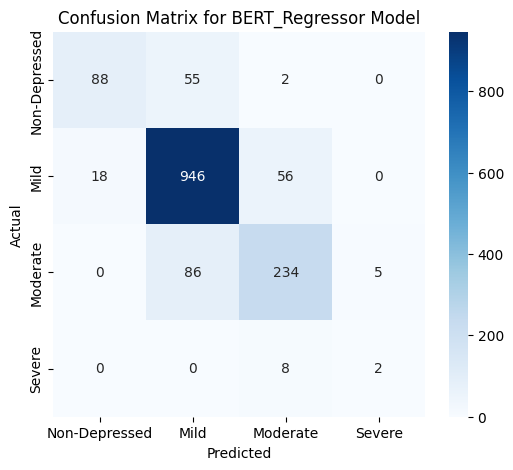


 Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.87      0.93      0.90      1020
         Mild       0.78      0.72      0.75       325
     Moderate       0.83      0.61      0.70       145
       Severe       0.29      0.20      0.24        10

     accuracy                           0.85      1500
    macro avg       0.69      0.61      0.65      1500
 weighted avg       0.84      0.85      0.84      1500



(0.0018457560800015926, 0.8030895590782166)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_bert(model, test_loader, model_path=None, device="cuda"):
    """
    Evaluates the trained BERTRegressor model on the test set.

    - Loads the best saved model if a `model_path` is provided.
    - Computes MSE and R² scores.
    - Converts regression outputs into classification labels for confusion matrix.
    - Prints evaluation results and plots a confusion matrix.
    """
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
    # Load the best saved model if path is provided
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )

            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays for analysis
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute MSE and R² scores
    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    print(f"\n BERTREGRESSOR Evaluation Results:")
    print(f"- Mean Squared Error (MSE): {mse:.4f}")
    print(f"- R² Score: {r2:.4f}")

    # Convert regression predictions to classification labels
    def categorize_depression(intensity):
        if intensity < 0.4:
            return "Non-Depressed"
        elif 0.4 <= intensity < 0.6:
            return "Mild"
        elif 0.6 <= intensity < 0.8:
            return "Moderate"
        else:
            return "Severe"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    # Compute Confusion Matrix
    cm = confusion_matrix(true_labels_class, predicted_labels_class, labels=["Non-Depressed", "Mild", "Moderate", "Severe"])

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"], yticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    # Print Classification Report
    print("\n Classification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class, target_names=["Non-Depressed", "Mild", "Moderate", "Severe"]))

    return mse, r2

#Run Evaluation
evaluate_model_bert(
    model=model,
    test_loader=test_loader_32,
    model_path= "/content/drive/MyDrive/New_Models/DISTILbert_32_model.pth"
)


In [ ]:
del model  # Delete previous model
torch.cuda.empty_cache()  # Clear GPU memory


In [ ]:
class DistilBERTRegression(nn.Module):
    def __init__(self):
        super(DistilBERTRegression, self).__init__()
        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.regressor = nn.Linear(self.distilbert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]  # Extract CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTRegression().to(device)


In [ ]:
# Create DataLoaders with batch size 64
train_loader_64 = DataLoader(train_dataset, batch_size=64, shuffle=True,
                             worker_init_fn=seed_worker, generator=g)
val_loader_64 = DataLoader(val_dataset, batch_size=64, shuffle=False,
                           worker_init_fn=seed_worker, generator=g)
test_loader_64 = DataLoader(test_dataset, batch_size=64, shuffle=False,
                            worker_init_fn=seed_worker, generator=g)

In [ ]:
# Training Function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_fn = nn.MSELoss()

# Training function with early stopping
def train_model_bert(model, train_loader, val_loader, optimizer, loss_fn, epochs=20, patience=3, device="cuda"):
    """
    Train the DISTILBERT model with early stopping and MSE tracking.

    - Stops training if validation loss does not improve after `patience` epochs.
    - Saves the best model automatically.
    - Applies gradient clipping for stability.
    """

    best_val_loss = float("inf")  # Initialize with a high value
    patience_counter = 0  # Counter to track non-improving epochs
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(outputs, labels)  # Compute MSE loss
            loss.backward()

            # Apply gradient clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            total_train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = (
                    batch["input_ids"].to(device),
                    batch["attention_mask"].to(device),
                    batch["labels"].to(device),
                )

                outputs = model(input_ids, attention_mask).squeeze()
                loss = loss_fn(outputs, labels)  # Compute MSE loss
                total_val_loss += loss.item()

        # Compute average validation loss
        avg_val_loss = total_val_loss / len(val_loader)

        # Print loss values for this epoch
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"-Train MSE Loss = {avg_train_loss:.6f}")
        print(f"-Validation MSE Loss = {avg_val_loss:.6f}")

        # **Early Stopping Logic**
        if (best_val_loss - avg_val_loss )>min_delta:
            best_val_loss = avg_val_loss  # Update best loss
            patience_counter = 0  # Reset patience counter
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "/content/drive/MyDrive/New_Models/DISTILbert_64_model.pth")
        else:
            patience_counter += 1  # Increment patience counter
            print(f"!!No improvement for {patience_counter} epochs.")

        # **Trigger Early Stopping if No Improvement for `patience` epochs**
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break  # Stop training

    print("Training complete :)")

# Call the training function to start training
EPOCHS = 20  # Increased epochs
PATIENCE = 3  # Stop if no improvement for 3 epochs

train_model_bert(
    model=model,
    train_loader=train_loader_32,
    val_loader=val_loader_32,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)


Epoch 1/20:
-Train MSE Loss = 0.021000
-Validation MSE Loss = 0.004844
Validation loss improved. Saving model...
Epoch 2/20:
-Train MSE Loss = 0.010185
-Validation MSE Loss = 0.005293
!!No improvement for 1 epochs.
Epoch 3/20:
-Train MSE Loss = 0.007169
-Validation MSE Loss = 0.003529
Validation loss improved. Saving model...
Epoch 4/20:
-Train MSE Loss = 0.005288
-Validation MSE Loss = 0.003462
Validation loss improved. Saving model...
Epoch 5/20:
-Train MSE Loss = 0.003898
-Validation MSE Loss = 0.002829
Validation loss improved. Saving model...
Epoch 6/20:
-Train MSE Loss = 0.002928
-Validation MSE Loss = 0.002679
Validation loss improved. Saving model...
Epoch 7/20:
-Train MSE Loss = 0.002364
-Validation MSE Loss = 0.002599
Validation loss improved. Saving model...
Epoch 8/20:
-Train MSE Loss = 0.001954
-Validation MSE Loss = 0.002458
Validation loss improved. Saving model...
Epoch 9/20:
-Train MSE Loss = 0.001571
-Validation MSE Loss = 0.002410
!!No improvement for 1 epochs.
Epoch

Loading best saved model for evaluation...
Model loaded successfully!

 BERTREGRESSOR Evaluation Results:
- Mean Squared Error (MSE): 0.0020
- R² Score: 0.7869


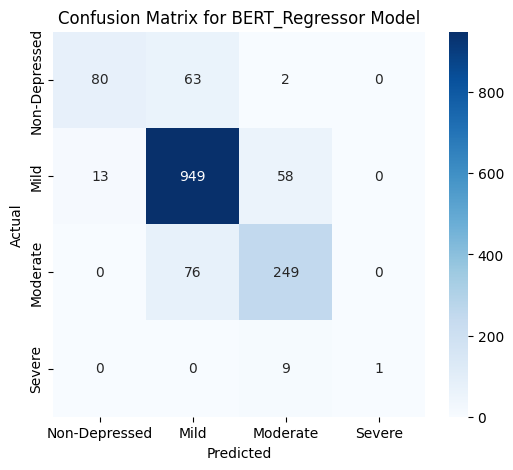


 Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.87      0.93      0.90      1020
         Mild       0.78      0.77      0.77       325
     Moderate       0.86      0.55      0.67       145
       Severe       1.00      0.10      0.18        10

     accuracy                           0.85      1500
    macro avg       0.88      0.59      0.63      1500
 weighted avg       0.85      0.85      0.85      1500



(0.0019975530449301004, 0.7868954539299011)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_bert(model, test_loader, model_path=None, device="cuda"):
    """
    Evaluates the trained BERTRegressor model on the test set.

    - Loads the best saved model if a `model_path` is provided.
    - Computes MSE and R² scores.
    - Converts regression outputs into classification labels for confusion matrix.
    - Prints evaluation results and plots a confusion matrix.
    """
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
    # Load the best saved model if path is provided
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )

            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays for analysis
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute MSE and R² scores
    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    print(f"\n BERTREGRESSOR Evaluation Results:")
    print(f"- Mean Squared Error (MSE): {mse:.4f}")
    print(f"- R² Score: {r2:.4f}")

    # Convert regression predictions to classification labels
    def categorize_depression(intensity):
        if intensity < 0.4:
            return "Non-Depressed"
        elif 0.4 <= intensity < 0.6:
            return "Mild"
        elif 0.6 <= intensity < 0.8:
            return "Moderate"
        else:
            return "Severe"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    # Compute Confusion Matrix
    cm = confusion_matrix(true_labels_class, predicted_labels_class, labels=["Non-Depressed", "Mild", "Moderate", "Severe"])

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"], yticklabels=["Non-Depressed", "Mild", "Moderate", "Severe"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    # Print Classification Report
    print("\n Classification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class, target_names=["Non-Depressed", "Mild", "Moderate", "Severe"]))

    return mse, r2

#Run Evaluation
evaluate_model_bert(
    model=model,
    test_loader=test_loader_32,
    model_path= "/content/drive/MyDrive/New_Models/DISTILbert_64_model.pth"
)
